In [48]:
# transformer_testing.py
import os, sys, json
import joblib
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score
import logging
import matplotlib.pyplot as plt

import sys
PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
SRC_DIR = str(Path(PROJECT_DIR) / "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from datetime import datetime
from config.settings_hpc import *

logging.basicConfig(level=logging.INFO, format='%(message)s')

# ---------------------------------------------------------------------
# Paths / config
# ---------------------------------------------------------------------


from multiomic_transformer.models.model import MultiomicTransformer
from multiomic_transformer.datasets.dataset import MultiChromosomeDataset, SimpleScaler, fit_simple_scalers

experiment = "model_training_chr19_5k"
SELECTED_EXPERIMENT_DIR = OUTPUT_DIR / "testing_chr19_cell_scaling" / experiment
gpu_log_file = Path(PROJECT_DIR) / "LOGS" / "transformer_logs" / "03_training" / "gpu_usage_transformer_training_3409721.20251106_105755.csv"

GROUND_TRUTH_DIR = os.path.join(PROJECT_DIR, "data/ground_truth_files")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH  = 32
TG_CHUNK = 64

## Investigating single-chromosome training accuracy scaling by cell count

In [53]:
chr19_2_5k_cell_training_df = pd.read_csv(
    OUTPUT_DIR / "testing_chr19_cell_scaling" / "model_training_chr19_2.5k" / "training_log.csv"
)
chr19_5k_cell_training_df = pd.read_csv(
    OUTPUT_DIR / "testing_chr19_cell_scaling" / "model_training_chr19_5k" / "training_log.csv"
)
chr19_10k_cell_training_df = pd.read_csv(
    OUTPUT_DIR / "testing_chr19_cell_scaling" / "model_training_chr19_10k" / "training_log.csv"
)
chr19_15k_cell_training_df = pd.read_csv(
    OUTPUT_DIR / "testing_chr19_cell_scaling" / "model_training_chr19_15k" / "training_log.csv"
)

In [55]:
chr19_15k_cell_training_df.head()

,Epoch,Train Total Loss,Train MSE,Val MSE,R2,LR
0,1,59.542883,59.542883,1.261002,-0.248155,0.001
1,2,0.997579,0.997579,0.769231,0.211803,0.001
2,3,0.701658,0.701658,0.621664,0.350187,0.001
3,4,0.567092,0.567092,0.533223,0.433810,0.001
4,5,0.512100,0.512100,0.489215,0.478009,0.001


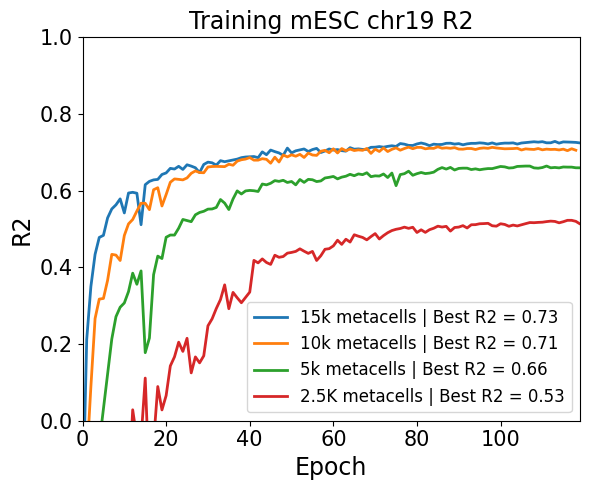

In [57]:
def plot_R2_across_epochs_multi_dfs(df_dict, dataset_name, chrom_id):
    fig = plt.figure(figsize=(6, 5))
    
    num_train_epochs = []
    for key, df in df_dict.items():
        plt.plot(df.index, df["R2"], linewidth=2, label=f"{key} | Best R2 = {df['R2'].max():.2f}")
        num_train_epochs.append(df["Epoch"].max())

    plt.title(f"Training {dataset_name} {chrom_id} R2", fontsize=17)
    plt.ylim((0,1))
    plt.xlim((0, min(num_train_epochs)))
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel("Epoch", fontsize=17)
    plt.ylabel("R2", fontsize=17)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    return fig

df_dict = {
    "15k metacells": chr19_15k_cell_training_df,
    "10k metacells": chr19_10k_cell_training_df,
    "5k metacells": chr19_5k_cell_training_df,
    "2.5K metacells": chr19_2_5k_cell_training_df,
    }

fig = plot_R2_across_epochs_multi_dfs(df_dict, "mESC", "chr19")
fig.savefig(OUTPUT_DIR / "testing_chr19_cell_scaling" / "val_r2_scaling_by_num_cells.png", dpi=300)
fig.show()

## GPU Usage Log

In [ ]:
gpu_logs = {
    "15k metacells": chr19_15k_cell_training_df,
    "10k metacells": chr19_10k_cell_training_df,
    "5k metacells": chr19_5k_cell_training_df,
    "2.5K metacells": chr19_2_5k_cell_training_df,
}

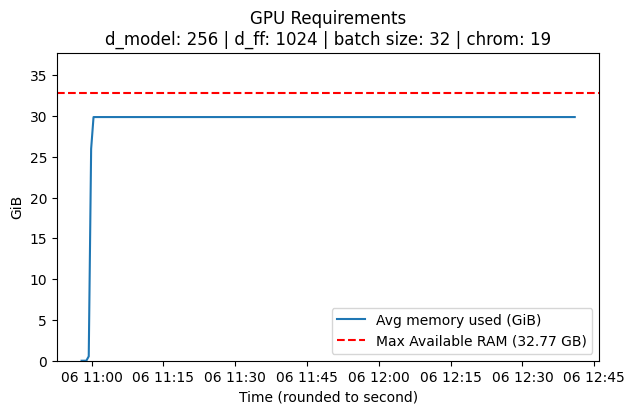

In [39]:
gpu_log_df = pd.read_csv(gpu_log_file, sep=",")
gpu = gpu_log_df.copy()
gpu.columns = gpu.columns.str.strip()
gpu["timestamp"] = pd.to_datetime(gpu["timestamp"], errors="coerce")
gpu["tsec"] = gpu["timestamp"].dt.floor("s")
gpu["memory_used_gib"]  = gpu["memory.used [MiB]"].astype(str).str.extract(r"(\d+)").astype(float) / 1000
gpu["memory_total_gib"] = gpu["memory.total [MiB]"].astype(str).str.extract(r"(\d+)").astype(float) / 1000

# mean over all GPUs at each second
mean_per_sec = (
    gpu.groupby("tsec", as_index=True)["memory_used_gib"]
       .mean()
       .sort_index()
)

# assume total is the same for all GPUs (take first)
total_gib = float(gpu["memory_total_gib"].iloc[0])

# plot
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(mean_per_sec.index, mean_per_sec.values, label="Avg memory used (GiB)")
ax.axhline(total_gib, linestyle="--", color="red", label=f"Max Available RAM ({total_gib:.2f} GB)")
ax.set_ylabel("GiB")
ax.set_xlabel("Time (rounded to second)")
ax.set_ylim((0, total_gib + 5))
ax.legend()
plt.title(
    f"GPU Requirements\n" \
    f"d_model: {D_MODEL} | d_ff: {D_FF} | batch size: {BATCH_SIZE} | chrom: 19"
    )
plt.show()
fig.savefig(SELECTED_EXPERIMENT_DIR / "gpu_memory_requirements.png", dpi=200)

## Training Evaluation

In [41]:
training_log_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "training_log.csv"), header=0)
gene_near_peaks_df = pd.read_parquet(os.path.join(SAMPLE_DATA_CACHE_DIR, CHROM_ID, f"genes_near_peaks_{CHROM_ID}.parquet"))
# tf_tg_mean_attention_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "tf_tg_mean_attention.csv"))

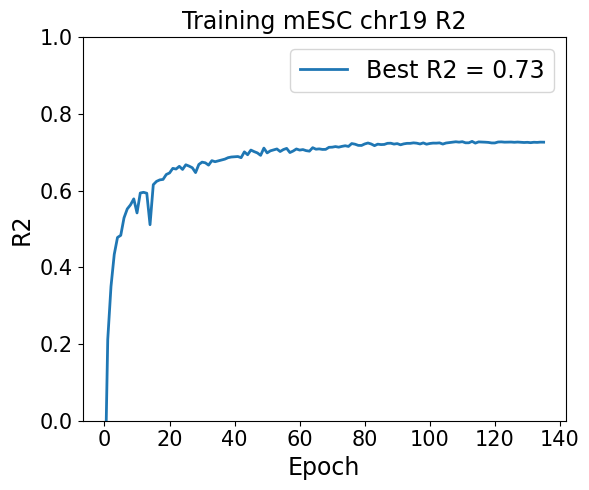

In [42]:
def plot_R2_across_epochs(df, dataset_name, chrom_id):
    fig = plt.figure(figsize=(6, 5))
    plt.plot(df.index, df["R2"], linewidth=2, label=f"Best R2 = {df['R2'].max():.2f}")

    plt.title(f"Training {dataset_name} {chrom_id} R2", fontsize=17)
    plt.ylim((0,1))
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel("Epoch", fontsize=17)
    plt.ylabel("R2", fontsize=17)
    plt.legend(fontsize=17)
    plt.tight_layout()
    
    return fig

fig = plot_R2_across_epochs(training_log_df, "mESC", "chr19")
fig.savefig(os.path.join(SELECTED_EXPERIMENT_DIR, "eval_results_pearson_corr.png"), dpi=300)
fig.show()

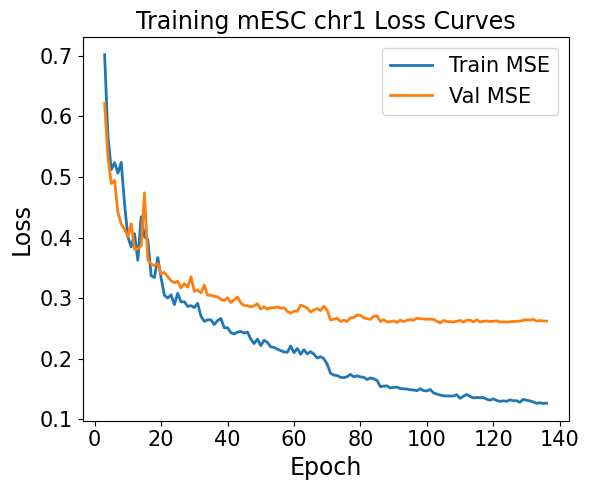

In [43]:
def plot_train_val_loss(df, dataset_name, chrom_id):
    fig = plt.figure(figsize=(6, 5))
    df = df.copy().iloc[2:, :]
    plt.plot(df["Epoch"], df["Train MSE"], label="Train MSE", linewidth=2)
    plt.plot(df["Epoch"], df["Val MSE"], label="Val MSE", linewidth=2)
    # plt.plot(df["Epoch"], df["Train Total Loss"], label="Train Total Loss", linestyle="--", alpha=0.7)

    plt.title(f"Training {dataset_name} {chrom_id} Loss Curves", fontsize=17)
    plt.xlabel("Epoch", fontsize=17)
    plt.ylabel("Loss", fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    # plt.ylim([0, 1])
    # plt.xlim(left=2)
    plt.legend(fontsize=15)
    plt.tight_layout()
    return fig
    
fig = plot_train_val_loss(training_log_df, "mESC", "chr1")
fig.savefig(os.path.join(SELECTED_EXPERIMENT_DIR, "eval_results_training_loss.png"), dpi=300)
fig.show()

In [6]:
gene_near_peaks_df = pd.read_parquet(os.path.join(SAMPLE_DATA_CACHE_DIR, CHROM_ID, f"genes_near_peaks_{CHROM_ID}.parquet"))
tf_tg_mean_attention_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "tf_tg_mean_attention.csv"))
# gradient_attribution_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "test_results/gradient_attribution.csv"), index_col=0)
# shortcut_matrix_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "test_results/shortcut_matrix.csv"), index_col=0)

In [49]:

import os
import torch
from torch.utils.data import DataLoader
from multiomic_transformer.scripts.train import prepare_dataloader

chrom_id = ["chr19"]

# Rebuild dataset to get vocab sizes consistent with training
dataset = MultiChromosomeDataset(
    data_dir=SAMPLE_DATA_CACHE_DIR,
    chrom_ids=chrom_id,
    tf_vocab_path=os.path.join(COMMON_DATA, "tf_vocab.json"),
    tg_vocab_path=os.path.join(COMMON_DATA, "tg_vocab.json"),
    max_cached=2,
    max_tfs=SUBSAMPLE_MAX_TFS,
    max_tgs=SUBSAMPLE_MAX_TGS,
    max_windows_per_chrom=SUBSAMPLE_MAX_WINDOWS_PER_CHROM,
    max_cells=SUBSAMPLE_MAX_CELLS,
    subset_seed=SUBSAMPLE_SEED,
)

train_loader, val_loader, test_loader = prepare_dataloader(
    dataset,
    batch_size=BATCH_SIZE,
    world_size=1,
    rank=0,
    num_workers=4,
    pin_memory=True,
    seed=42,         # must match training seed
    drop_last=True,
)

tf_vocab_size = len(dataset.tf_name2id_sub)
tg_vocab_size = len(dataset.tg_name2id_sub)

# 2) Recreate the same model architecture
model = MultiomicTransformer(
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    d_ff=D_FF,
    dropout=DROPOUT,
    tf_vocab_size=tf_vocab_size,
    tg_vocab_size=tg_vocab_size,
    bias_scale=ATTN_BIAS_SCALE,
    use_bias=USE_DISTANCE_BIAS,
    use_shortcut=USE_SHORTCUT,
    use_motif_mask=USE_MOTIF_MASK,
    lambda_l1=SHORTCUT_L1,
    lambda_l2=SHORTCUT_L2,
    topk=SHORTCUT_TOPK,
    shortcut_dropout=SHORTCUT_DROPOUT,
)

# 3) Load checkpoint
ckpt_path = os.path.join(SELECTED_EXPERIMENT_DIR, "trained_model.pt")
state = torch.load(ckpt_path, map_location="cuda:0")  # or map_location=device

# handle both pure state_dict and {"model_state_dict": ...}
if isinstance(state, dict) and "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
else:
    model.load_state_dict(state)

model.eval()  # if you're going to use it for inference

tf_scaler = SimpleScaler(
    mean=state["tf_scaler_mean"],
    std=state["tf_scaler_std"],
)
tg_scaler = SimpleScaler(
    mean=state["tg_scaler_mean"],
    std=state["tg_scaler_std"],
)


Global mean per-gene R²: 0.6910
Per-gene R² stats: min=-0.015, median=0.757, max=0.985


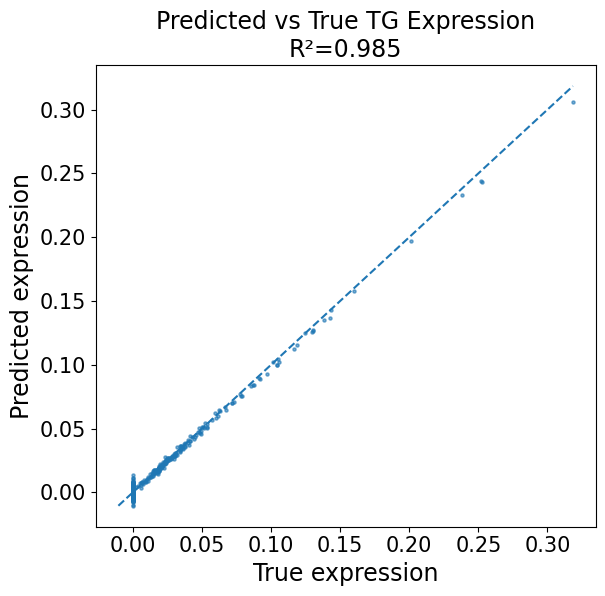

In [52]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def inverse_transform(scaler: SimpleScaler, x: torch.Tensor, ids: torch.Tensor) -> torch.Tensor:
    """
    x: [B, G_eval] or [B, T_eval]
    ids: [G_eval] or [T_eval] global indices used during transform
    """
    mu  = scaler.mean.index_select(0, ids.to(scaler.mean.device))
    sig = scaler.std.index_select(0, ids.to(scaler.std.device)).clamp_min(1e-6)
    # broadcast over batch
    while mu.dim() < x.dim():
        mu = mu.unsqueeze(0)
        sig = sig.unsqueeze(0)
    return x * sig + mu


def per_gene_r2(tgts: np.ndarray, preds: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    # tgts, preds: [N, G]
    y_true = tgts.astype(np.float64)
    y_pred = preds.astype(np.float64)

    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = np.where(mask, y_true, 0.0)
    y_pred = np.where(mask, y_pred, 0.0)

    y_mean = y_true.mean(axis=0, keepdims=True)
    sst = np.sum((y_true - y_mean) ** 2, axis=0)
    sse = np.sum((y_true - y_pred) ** 2, axis=0)

    r2 = np.zeros_like(sst)
    valid = sst > eps
    r2[valid] = 1.0 - sse[valid] / (sst[valid] + eps)
    return r2


import matplotlib.pyplot as plt

def plot_per_gene_r2_scatterplot(model, dataloader, tf_scaler, tg_scaler,
                                 device="cpu", max_batches=None, outpath=None):
    model.to(device)
    model.eval()

    preds_list, tgts_list = [], []

    with torch.no_grad():
        for b_idx, batch in enumerate(dataloader):
            if max_batches is not None and b_idx >= max_batches:
                break

            (atac_wins,
             tf_tensor,
             targets,
             bias,
             tf_ids,
             tg_ids,
             motif_mask) = batch

            atac_wins = atac_wins.to(device)
            tf_tensor = tf_tensor.to(device)
            targets   = targets.to(device)
            bias      = bias.to(device)
            tf_ids    = tf_ids.to(device)
            tg_ids    = tg_ids.to(device)
            motif_mask= motif_mask.to(device)

            # --- scale TFs as in training ---
            tf_in = tf_scaler.transform(tf_tensor, ids=tf_ids)

            # model predicts in scaled TG space
            preds_scaled, _ = model(
                atac_wins,
                tf_in,
                tf_ids=tf_ids,
                tg_ids=tg_ids,
                bias=bias,
                motif_mask=motif_mask,
            )

            # --- unscale preds back to original TG space ---
            preds_orig = inverse_transform(tg_scaler, preds_scaled, ids=tg_ids)

            preds_list.append(preds_orig.cpu())
            tgts_list.append(targets.cpu())  # targets already original scale

    if not preds_list:
        print("No data in dataloader.")
        return

    preds = torch.cat(preds_list, dim=0).numpy()  # [N, G]
    tgts  = torch.cat(tgts_list,  dim=0).numpy()  # [N, G]

    # per-gene R²
    r2_vec = per_gene_r2(tgts, preds)
    global_r2 = float(np.mean(r2_vec))
    print(f"Global mean per-gene R²: {global_r2:.4f}")
    print(f"Per-gene R² stats: min={r2_vec.min():.3f}, median={np.median(r2_vec):.3f}, max={r2_vec.max():.3f}")

    # Optional: scatter for a single gene (e.g. best gene)
    g_best = int(np.argmax(r2_vec))
    y_true = tgts[:, g_best]
    y_pred = preds[:, g_best]

    # subsample if huge
    max_points = 50000
    if y_true.size > max_points:
        idx = np.random.choice(y_true.size, size=max_points, replace=False)
        y_true = y_true[idx]
        y_pred = y_pred[idx]

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, s=5)
    lim_min = min(y_true.min(), y_pred.min())
    lim_max = max(y_true.max(), y_pred.max())
    plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle="--")
    plt.xlabel("True expression",fontsize=17)
    plt.ylabel("Predicted expression", fontsize=17)
    plt.title(f"Predicted vs True TG Expression\nR²={r2_vec[g_best]:.3f}", fontsize=17)
    plt.tight_layout()
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    if outpath:
        plt.savefig(outpath, dpi=300)
        plt.show()
    else:
        plt.show()

plot_per_gene_r2_scatterplot(
    model,
    train_loader,
    tf_scaler=tf_scaler,
    tg_scaler=tg_scaler,
    device="cuda:0",
    max_batches=100,
    outpath=os.path.join(SELECTED_EXPERIMENT_DIR, "eval_per_gene_r2_scatter.png")
)

## Gradient Attribution

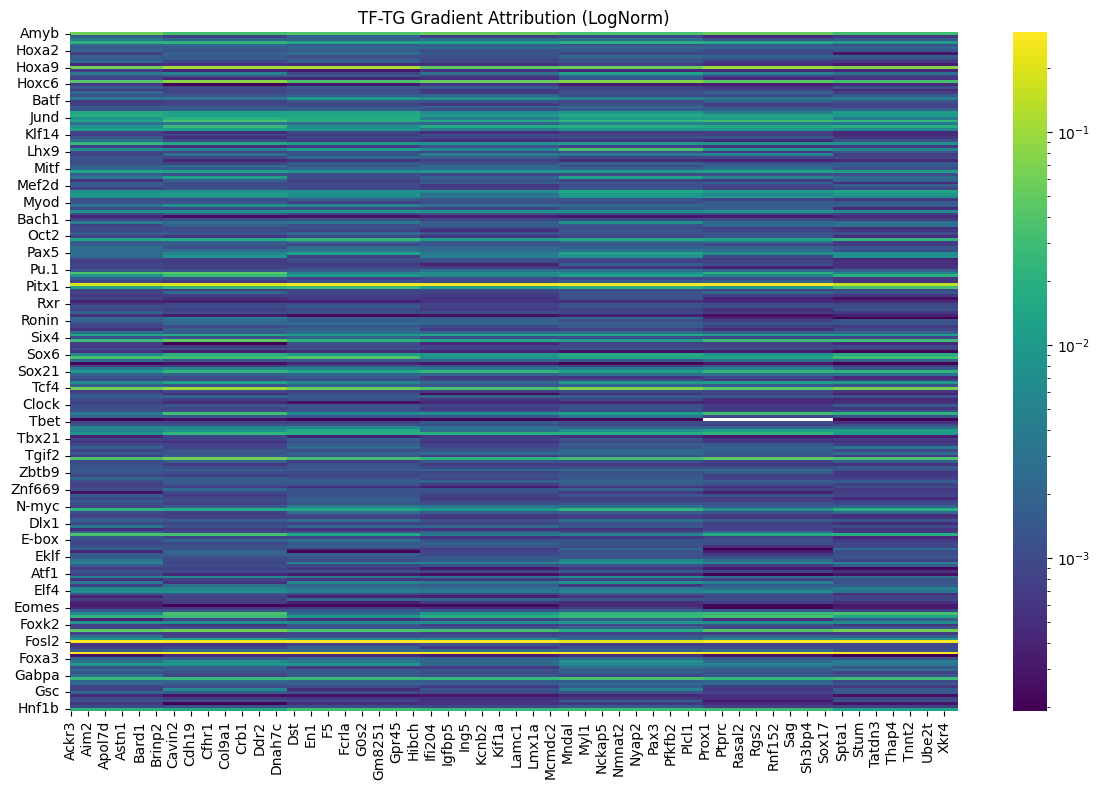

In [8]:
import seaborn as sns
from matplotlib.colors import LogNorm

df_subset = gradient_attribution_df.loc[
    [idx for idx in gradient_attribution_df.index if len(str(idx)) < 7],      # row filter
    [col for col in gradient_attribution_df.columns if len(str(col)) < 7]    # column filter
]

data = df_subset.iloc[:100, :100].copy()
vmin = max(1e-9, float(data[data > 0].min().min()))
vmax = float(data.max().max())

plt.figure(figsize=(12,8))
sns.heatmap(df_subset, cmap="viridis", norm=LogNorm(vmin=vmin, vmax=vmax))
plt.title("TF-TG Gradient Attribution (LogNorm)")
plt.tight_layout()
plt.show()

## Shortcut Matrix

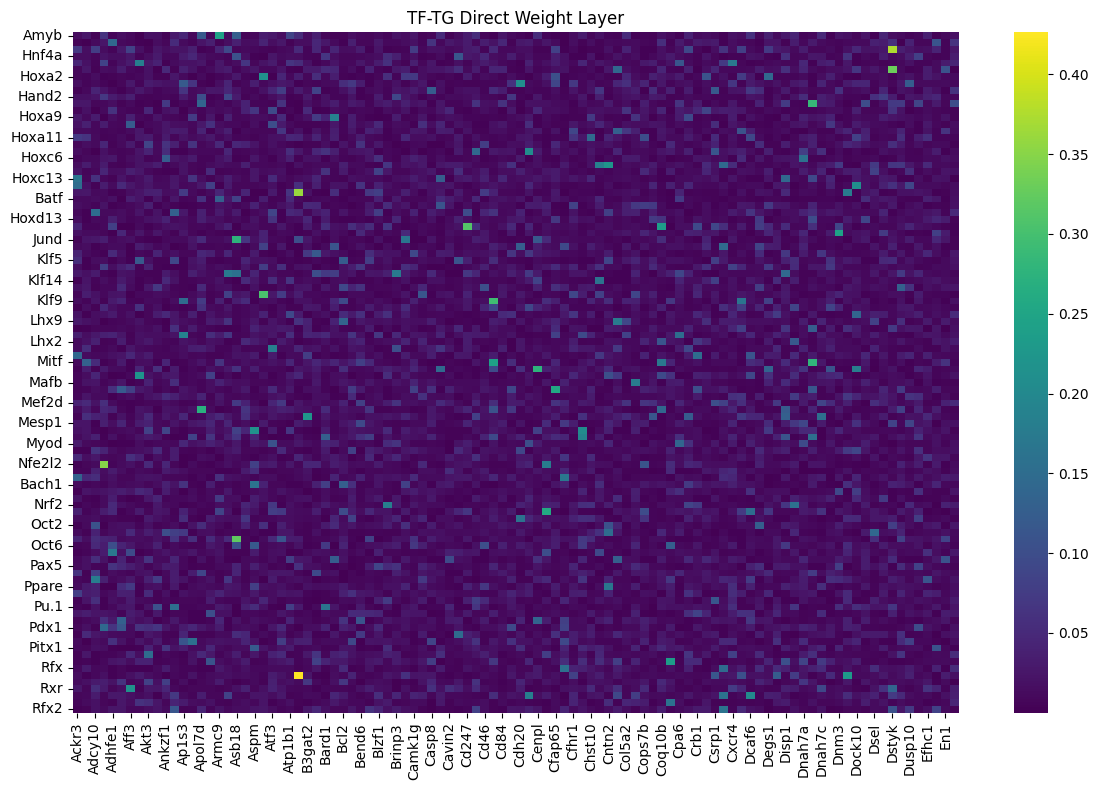

In [7]:
import seaborn as sns

df_subset = shortcut_matrix_df.loc[
    [idx for idx in shortcut_matrix_df.index if len(str(idx)) < 7],      # row filter
    [col for col in shortcut_matrix_df.columns if len(str(col)) < 7]    # column filter
]
plt.figure(figsize=(12,8))
sns.heatmap(df_subset.iloc[:100, :100], cmap="viridis")
plt.title("TF-TG Direct Weight Layer")
plt.tight_layout()
plt.show()

In [11]:
tf_imp_dir = os.path.join(SELECTED_EXPERIMENT_DIR, "test_results")
            
tf_importance_df = pd.read_csv(os.path.join(tf_imp_dir, "shortcut_matrix.csv"), header=0, index_col=0)

fig = plt.figure(figsize=(10,5))

selected_tg = tf_importance_df.index[0]
selected_tf_row = tf_importance_df.iloc[0]
selected_tf_row = selected_tf_row.iloc[:50].sort_values(ascending=False)

plt.xticks(rotation=90, fontsize=10)
plt.bar(x=selected_tf_row.index, height=selected_tf_row)
plt.title(f"TF Importance for {selected_tg}")
plt.ylabel("TF Importance")
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/mESC_no_scale_linear/chr1/model_training_021/test_results/shortcut_matrix.csv'

In [30]:
from grn_inference.utils import minmax_norm_col

In [31]:
edges_df = (
    tf_importance_df
    .reset_index()
    .melt(id_vars="index", var_name="Target", value_name="score")
    .rename(columns={"index": "Source"})
)

print(edges_df.head())
edges_df["score"] = minmax_norm_col(edges_df["score"])
edges_df.to_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "inferred_grn.csv"), header=True, index=False)

  Source         Target     score
0   Amyb  1110059e24rik  0.012926
1   Ap-1  1110059e24rik  0.007593
2  Atoh1  1110059e24rik  0.002979
3  Hnf4a  1110059e24rik  0.016630
4   Hnf6  1110059e24rik  0.059909


In [ ]:
tf_importance_df.melt()

,1110059e24rik,1700028p14rik,1700054a03rik,4430402i18rik,4930414n06rik,4930481a15rik,4930505n22rik,A1cf,A330040f15rik,A930007i19rik,...,Trpt1,Tsga10ip,Unc93b1,Vldlr,Vps13a,Vti1a,Vwa2,Wnt8b,Yif1a,Zfand5
Amyb,0.012926,0.007979,0.016949,0.071295,0.038051,0.005369,0.004322,0.052676,0.039596,0.004102,...,0.021498,0.008520,0.030714,0.005480,0.018128,0.010033,0.005197,0.023149,0.054277,0.013118
Ap-1,0.007593,0.016408,0.060694,0.075351,0.003203,0.018191,0.025439,0.010395,0.014900,0.006479,...,0.005965,0.112763,0.024329,0.004895,0.008635,0.009053,0.069101,0.052359,0.032719,0.007553
Atoh1,0.002979,0.008848,0.006363,0.017177,0.027394,0.096839,0.007401,0.006691,0.040941,0.011984,...,0.007331,0.024119,0.021316,0.077002,0.085251,0.058651,0.088675,0.007731,0.019807,0.007677
Hnf4a,0.016630,0.025051,0.012493,0.036420,0.022744,0.012015,0.047341,0.020354,0.005996,0.003615,...,0.006587,0.020681,0.005124,0.049497,0.018169,0.001901,0.020302,0.002485,0.004840,0.071207
Hnf6,0.059909,0.013033,0.030434,0.009828,0.022351,0.014792,0.024875,0.005045,0.006072,0.004852,...,0.052047,0.005143,0.016318,0.004523,0.032682,0.002094,0.002916,0.013019,0.024267,0.088734


In [26]:
def evaluate_chip_aucs(tf_importance_df, chip_df, k_list=(100, 500, 1000, 5000)):
    """
    Evaluate AUROC / PR-AUC / Precision K against CHIP edges.
    We uppercase both the CHIP and the DF indexing to align.
    """
    chip_edges = {(t.upper(), g.upper()) for t, g in zip(chip_df["TF"], chip_df["TG"])}

    # Uppercase DF indexing for matching
    tf_imp = tf_importance_df.copy()
    tf_imp.index   = [x.upper() for x in tf_imp.index]
    tf_imp.columns = [x.upper() for x in tf_imp.columns]

    rn111_tfs = {t for t, _ in chip_edges}
    rn111_tgs = {g for _, g in chip_edges}

    tf_imp = tf_imp.loc[tf_imp.index.intersection(rn111_tfs),
                        tf_imp.columns.intersection(rn111_tgs)]
    if tf_imp.empty:
        raise ValueError("No overlap between TF/TG names and CHIP set.")

    scores, labels, edges = [], [], []
    # Flatten
    for tg in tf_imp.columns:
        col = tf_imp[tg]
        for tf, score in col.items():
            scores.append(float(score))
            labels.append(1 if (tf, tg) in chip_edges else 0)
            edges.append((tf, tg))

    if len(set(labels)) < 2:
        raise ValueError("Only one class present after overlap; AUROC/PR-AUC undefined.")

    auroc = roc_auc_score(labels, scores)
    auprc = average_precision_score(labels, scores)

    # Precision K
    df_scored = pd.DataFrame(edges, columns=["tf", "tg"])
    df_scored["score"] = scores
    df_scored["label"] = labels
    df_scored = df_scored.sort_values("score", ascending=False).reset_index(drop=True)

    results = {"AUROC": auroc, "PR-AUC": auprc, "positives": int(sum(labels)), "edges": int(len(labels))}
    for k in k_list:
        k = int(k)
        if k <= len(df_scored):
            prec_k = df_scored.head(k)["label"].mean()
            results[f"Precision@{k}"] = float(prec_k)

    return results, df_scored

results, df_scored = evaluate_chip_aucs(tf_importance_df, rn115_ground_truth, k_list=(100, 500, 1000, 5000))

print(f"AUROC = {results['AUROC']:.4f}  |  PR-AUC = {results['PR-AUC']:.4f}  "
        f"| positives={results['positives']} / {results['edges']} edges")
for k in (100, 500, 1000, 5000):
    key = f"AUROC@{k}"
    if key in results:
        print(f"{key}: {results[key]:.3f}")


AUROC = 0.5003  |  PR-AUC = 0.1710  | positives=397 / 2544 edges


In [ ]:
import torch
training_data_cache = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/training_data_cache/mESC"

total_moods_site_df_list = []
peak_gene_dist_df_list = []

for subdir in os.listdir(training_data_cache):
    if "chr" in subdir:
        chr_path = os.path.join(training_data_cache, subdir)
        
        moods_path = os.path.join(chr_path, f"moods_sites_{subdir}.tsv")
        peak_gene_dist = os.path.join(chr_path, f"genes_near_peaks_{subdir}.parquet")
        
        if os.path.isfile(moods_path):
            chr_moods_sites_df = pd.read_csv(moods_path, sep="\t")
            total_moods_site_df_list.append(chr_moods_sites_df)
            
        if os.path.isfile(peak_gene_dist):
            chr_peak_gene_dist_df = pd.read_parquet(peak_gene_dist, engine="pyarrow")
            peak_gene_dist_df_list.append(chr_peak_gene_dist_df)

total_moods_sites = pd.concat(total_moods_site_df_list)
total_peak_gene_dist = pd.concat(peak_gene_dist_df_list)


In [37]:
print("Moods DataFrame")
print(total_moods_sites.head())
print()
print("peak-gene distance dataframe")
print(total_peak_gene_dist.head())

Moods DataFrame
                    peak_id         TF    pos   logodds strand
0  chr5:100004870-100005470  At3g46070  285.0  4.201540      -
1  chr5:100007878-100008478  At3g46070  162.0  4.902650      -
2  chr5:100039792-100040392  At3g46070  559.0  3.333572      -
3  chr5:100047809-100048409  At3g46070   73.0  4.902650      +
4  chr5:100053808-100054408  At3g46070  496.0  4.902650      -

peak-gene distance dataframe
       peak_chr  peak_start   peak_end                   peak_id gene_chr  \
152413     chr5   146230649  146231249  chr5:146230649-146231249     chr5   
30781      chr5   113772200  113772800  chr5:113772200-113772800     chr5   
176649     chr5    24901975   24902575    chr5:24901975-24902575     chr5   
81751      chr5   124174791  124175391  chr5:124174791-124175391     chr5   
103648     chr5   135064344  135064944  chr5:135064344-135064944     chr5   

        gene_start   gene_end     target_id  TSS_dist  TSS_dist_score  
152413   146231249  146231249          Cd

In [38]:
tf_tg_links = total_moods_sites.merge(total_peak_gene_dist, on="peak_id", how="inner")
print(tf_tg_links.head())

MemoryError: Unable to allocate 51.9 GiB for an array with shape (2, 3479631642) and data type object

In [ ]:
tf_tg_features = (
    tf_tg_links.groupby(["TF", "target_id"])
    .agg(
        n_peaks_linking=("peak_id", "nunique"),
        n_motifs_linking=("logodds", "count"),
        mean_motif_score=("logodds", "mean"),
        max_motif_score=("logodds", "max"),
        min_tss_dist=("TSS_dist", "min"),
        mean_tss_dist=("TSS_dist", "mean"),
        mean_tss_score=("TSS_dist_score", "mean")
    )
    .reset_index()
    .rename(columns={"target_id": "TG"})
)
print(tf_tg_features.head())

In [ ]:
tf_tg_features["motif_density"] = (
    tf_tg_features["n_motifs_linking"] / (tf_tg_features["n_peaks_linking"] + 1e-6)
)
tf_tg_features["log_mean_score"] = np.log1p(tf_tg_features["mean_motif_score"])
tf_tg_features["neg_log_tss"] = -np.log1p(tf_tg_features["mean_tss_dist"])
